# Boosted Decision Tree (BDT) for $H \rightarrow (\rho:\phi)+\gamma$ Analysis

In [41]:
# General
import os, sys
# Handling ROOT files
import numpy as np
import uproot
import pandas as pd
# Plotting
import matplotlib
from matplottery import Hist1D, Hist2D, plot_stack
import matplotlib.pyplot as plt
# Machine Learning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT
import ast
import json
# Custom Tools
from data import GetData
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

## Global Variables

In [42]:
# Manualy set signal name
signal = "WH_HtoRhoGammaPhiGamma"

## Get Data

In [43]:
# Get dataframes
dataframes = GetData("outputs", verbose=True)

Loaded Dataframes:
    TTJets_SingleLeptFromT
    TTGamma_SingleLeptFromTbar
    WGToLNuG
    TTJets_SingleLeptFromTbar
    WJetsToLNu
    WH_HtoRhoGammaPhiGamma
    TTGamma_SingleLeptFromT


In [44]:
# Get list of sample names
samples = dataframes.keys()
# Move signal name to front
samples.insert(0, samples.pop(samples.index(signal)))
# Print sample names
print("Branch Names:\n"+", ".join(samples))

Branch Names:
WH_HtoRhoGammaPhiGamma, TTJets_SingleLeptFromT, TTGamma_SingleLeptFromTbar, WGToLNuG, TTJets_SingleLeptFromTbar, WJetsToLNu, TTGamma_SingleLeptFromT


In [45]:
# Get list of branch names
branches = dataframes[signal].keys()
# Print branch names
print("Branch Names:\n"+", ".join(branches))

Branch Names:
run, lumi, event, scale1fb, genRecoGamma_dR, genRecoPhi_dR, genRecoRho_dR, genW_pt, genW_eta, genW_phi, genW_mass, genWLepton_id, genWLepton_pt, genWLepton_eta, genWLepton_phi, genHiggs_pt, genHiggs_eta, genHiggs_phi, genHiggs_mass, genHiggsMeson_id, genHiggsMeson_pt, genHiggsMeson_eta, genHiggsMeson_phi, genHiggsMeson_mass, genHiggsMesonGamma_dR, genKm_pt, genKm_phi, genKm_eta, genKp_pt, genKp_phi, genKp_eta, genKpKm_dR, genGamma_pt, genGamma_phi, genGamma_eta, recoHiggs_mass, recoMeson_nCands, recoPhi_mass, recoPhi_pt, recoPhi_eta, recoPhi_phi, recoPhi_iso, recoKm_pt, recoKm_eta, recoKm_phi, recoKm_iso, recoKp_pt, recoKp_eta, recoKp_phi, recoKp_iso, recoKpKm_dR, recoRho_mass, recoRho_pt, recoRho_eta, recoRho_phi, recoRho_iso, recoPim_pt, recoPim_eta, recoPim_phi, recoPim_iso, recoPip_pt, recoPip_eta, recoPip_phi, recoPip_iso, recoPipPim_dR, recoGamma_pt, recoGamma_phi, recoGamma_eta, recoGamma_iso, genRecoGamma_isMatch, minGammaParton_dR, recoWLepton_id, recoWLepton_pt,

In [46]:
# Add signal bool and dataset name columns
for name, df in dataframes.iteritems():
    df["stype"] = samples.index(name)
    df["signal"] = (df["stype"] == 0)

# Concatenate dataframes
data = pd.concat(dataframes.values())
        
# Get bookkeeping columns to exclude in training
exclude = ["signal", "stype", "run", "lumi", "event", "scale1fb",
           "recoMeson_nCands", "recoWLepton_nLep", "minGammaParton_dR"]
for bname in branches:
    if "gen" in bname: exclude.append(bname)
    elif "_mass" in bname: exclude.append(bname)

# Collect selected features
features = sorted(list(set(df.columns.values)-set(exclude)))

In [47]:
# Display selected features
print("Selected Feature Names:\n"+", ".join(features))
# Display excluded features
print("Excluded Feature Names:\n"+", ".join(exclude))

Selected Feature Names:
recoGamma_eta, recoGamma_iso, recoGamma_phi, recoGamma_pt, recoKm_eta, recoKm_iso, recoKm_phi, recoKm_pt, recoKpKm_dR, recoKp_eta, recoKp_iso, recoKp_phi, recoKp_pt, recoPhi_eta, recoPhi_iso, recoPhi_phi, recoPhi_pt, recoPim_eta, recoPim_iso, recoPim_phi, recoPim_pt, recoPipPim_dR, recoPip_eta, recoPip_iso, recoPip_phi, recoPip_pt, recoRho_eta, recoRho_iso, recoRho_phi, recoRho_pt, recoWLepton_eta, recoWLepton_id, recoWLepton_phi, recoWLepton_pt
Excluded Feature Names:
signal, stype, run, lumi, event, scale1fb, recoMeson_nCands, recoWLepton_nLep, minGammaParton_dR, genRecoGamma_dR, genRecoPhi_dR, genRecoRho_dR, genW_pt, genW_eta, genW_phi, genW_mass, genWLepton_id, genWLepton_pt, genWLepton_eta, genWLepton_phi, genHiggs_pt, genHiggs_eta, genHiggs_phi, genHiggs_mass, genHiggsMeson_id, genHiggsMeson_pt, genHiggsMeson_eta, genHiggsMeson_phi, genHiggsMeson_mass, genHiggsMesonGamma_dR, genKm_pt, genKm_phi, genKm_eta, genKp_pt, genKp_phi, genKp_eta, genKpKm_dR, genGam

In [48]:
# Weigh *_pt columns by reco Higgs mass
for col in data.columns:
    if "_pt" in col and col not in exclude:
        data[col] = np.where(data[col] != -999, data[col], data[col]/data["recoHiggs_mass"])

In [49]:
# Split dataframe for training and testing
dummyWeights = np.ones(len(data["signal"])) # in place of data["weights"]
x_train, x_test, y_train, y_test, stype_train, stype_test, weights_train, weights_test = train_test_split(
                data[features],
                data["signal"],
                data["stype"],
                dummyWeights,
                test_size=0.25, random_state=42,
                )

## Train BDT

In [51]:
dump_name = "rpg.h"

# Sample selection (stype == 0 <--> signal)
sel_test = ( (stype_test == 0) | (stype_test == samples.index("WJetsToLNu")) )
sel_train = ( (stype_train == 0) | (stype_train == samples.index("WJetsToLNu")) )

# BDT Input
dtrain = xgb.DMatrix( x_train[sel_train], label=y_train[sel_train], weight=np.abs(weights_train[sel_train]))
dtest = xgb.DMatrix( x_test[sel_test], label=y_test[sel_test], weight=np.abs(weights_test[sel_test]))
evallist  = [(dtrain,'train'), (dtest,'eval')]

# BDT Parameters Setup
param = {}
param['objective'] = 'binary:logistic'

# BDT Knobs (Parameters)
num_round = 20
param['eta'] = 0.07
param['max_depth'] = 4
param['silent'] = 1
param['nthread'] = 4
param['eval_metric'] = "auc"
param['subsample'] = 0.6
param['alpha'] = 8.0
param['gamma'] = 2.0
param['lambda'] = 1.0
param['min_child_weight'] = 1.0
param['colsample_bytree'] = 1.0

In [52]:
# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label()==1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label()==0]).sum()
param["scale_pos_weight"] = sumw_neg/sumw_pos

In [53]:
# Train
bst = xgb.train( param.items(), dtrain, num_round, evallist, early_stopping_rounds=15 )

[0]	train-auc:0.946982	eval-auc:0.946031
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 15 rounds.
[1]	train-auc:0.951873	eval-auc:0.951112
[2]	train-auc:0.95212	eval-auc:0.951507
[3]	train-auc:0.953294	eval-auc:0.952483
[4]	train-auc:0.956746	eval-auc:0.955954
[5]	train-auc:0.957315	eval-auc:0.956584
[6]	train-auc:0.958971	eval-auc:0.95828
[7]	train-auc:0.959274	eval-auc:0.958591
[8]	train-auc:0.959409	eval-auc:0.958736
[9]	train-auc:0.959842	eval-auc:0.95914
[10]	train-auc:0.960478	eval-auc:0.959789
[11]	train-auc:0.961201	eval-auc:0.960456
[12]	train-auc:0.961881	eval-auc:0.961097
[13]	train-auc:0.961986	eval-auc:0.96123
[14]	train-auc:0.962355	eval-auc:0.961601
[15]	train-auc:0.963032	eval-auc:0.962295
[16]	train-auc:0.963261	eval-auc:0.962498
[17]	train-auc:0.963616	eval-auc:0.962868
[18]	train-auc:0.96395	eval-auc:0.963211
[19]	train-auc:0.964188	eval-auc:0.963411


In [54]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(x_train))
preds_test = bst.predict(xgb.DMatrix(x_test))

## Evaluate Performance

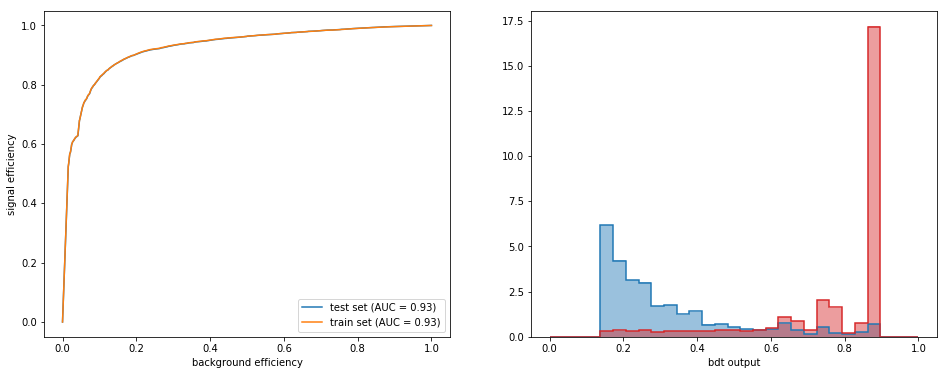

In [66]:
# Suplots setup
fig, axes = plt.subplots(1,2,figsize=(16,6))

# Subplot 1: Plot ROC curves
plt.subplot(1, 2, 1)
# Test ROC Curve
fpr, tpr, thresh = roc_curve(y_test,preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Train ROC Curve
fpr, tpr, thresh = roc_curve(y_train,preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();

# Subplot 2: Plot distribution of BDT outputs
plt.subplot(1, 2, 2)
bins = np.linspace(0.,1.,30)
# Training - Background
plt.hist(preds_train[y_train==0], weights=weights_train[y_train==0], bins=bins,histtype="stepfilled",alpha=0.45, density=True, label="bkg, train",color="C0");
# Training - Signal
plt.hist(preds_train[y_train==1], weights=weights_train[y_train==1], bins=bins,histtype="stepfilled",alpha=0.45, density=True, label="sig, train",color="C3");
# Testing - Background
plt.hist(preds_test[y_test==0], weights=weights_test[y_test==0], bins=bins,histtype="step",alpha=1.0, density=True, label="bkg, test",color="C0", lw=1.5, linestyle="solid");
# Testing - Signal
plt.hist(preds_test[y_test==1], weights=weights_test[y_test==1], bins=bins,histtype="step",alpha=1.0, density=True, label="sig, test",color="C3", lw=1.5, linestyle="solid");
# Settings
plt.xlabel("bdt output");

In [145]:
# Get cut scores
scores = bst.get_score(importance_type='gain')
# Print as table
length = 0
for cut in scores.keys():
    if len(cut) > length:
        length = len(cut)
print ("| Cut{0:{length}} | Gain{0:<{length}}|".format("", length=length-3))
for cut, gain in sorted(scores.items(), key=lambda kv:kv[1]):
#     print ("|{0:{length}}|{0:{length}}|".format("-", length=length-3, align="left"))
    print ("| {0:<{length}} | {1:<{length}} |".format(cut, gain, length=length))

| Cut             | Gain            |
| recoPim_iso     | 14.4100675467   |
| recoKp_iso      | 19.5235481      |
| recoKm_iso      | 190.265847225   |
| recoPim_pt      | 274.60323445    |
| recoWLepton_eta | 338.336456      |
| recoPip_iso     | 369.78368975    |
| recoKm_pt       | 390.89975       |
| recoWLepton_pt  | 447.316653534   |
| recoKpKm_dR     | 451.792673091   |
| recoKp_pt       | 574.299438      |
| recoWLepton_phi | 1336.45825      |
| recoPhi_pt      | 1474.49772553   |
| recoPipPim_dR   | 1655.76086379   |
| recoRho_iso     | 2308.0697007    |
| recoPhi_iso     | 3069.01198751   |
| recoRho_pt      | 5511.55700076   |
| recoGamma_pt    | 8158.4117049    |
| recoGamma_eta   | 36714.6516      |


In [16]:
# # Make a classifier and fit it on the training set, feeding in event weights as well
# bdt = GradientBoostingClassifier(n_estimators=200,max_depth=4,min_samples_split=2,learning_rate=0.07,verbose=True)
# bdt.fit(x_train, y_train, sample_weight=weights_train)

# # Variable importance after training
# print("Variable ranking")
# print("-"*15)